In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
!pip install rarfile

In [ ]:
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image

# Download the RAR file
url = 'https://drive.google.com/uc?id=1VVJ_lo2Z85MhIQ395W13opPoHQRQUKMJ'
output_rar = '/content/Chest_XRay_Dataset.rar'
gdown.download(url, output_rar, quiet=False)

# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')

Downloading...
From (original): https://drive.google.com/uc?id=1VVJ_lo2Z85MhIQ395W13opPoHQRQUKMJ
From (redirected): https://drive.google.com/uc?id=1VVJ_lo2Z85MhIQ395W13opPoHQRQUKMJ&confirm=t&uuid=9ffa14d7-199b-481a-846e-34c8e0f715e9
To: /content/Chest_XRay_Dataset.rar
100%|██████████| 38.0M/38.0M [00:01<00:00, 26.6MB/s]


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
    GlobalAveragePooling2D, Dense, concatenate, AveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Dataset path
data_dir = "/content/Chest_XRay_Dataset"  # Corrected dataset path

# Define a Dense Block
def dense_block(x, num_layers, growth_rate, activation='relu'):
    for _ in range(num_layers):
        # Bottleneck Layer
        bn = BatchNormalization()(x)
        act = Activation(activation)(bn)
        conv = Conv2D(4 * growth_rate, (1, 1), padding='same', kernel_initializer='he_normal')(act)

        # 3x3 Convolution Layer
        bn = BatchNormalization()(conv)
        act = Activation(activation)(bn)
        conv = Conv2D(growth_rate, (3, 3), padding='same', kernel_initializer='he_normal')(act)

        # Concatenate
        x = concatenate([x, conv])
    return x

# Transition Block
def transition_block(x, compression=0.5, activation='relu'):
    num_filters = int(tf.keras.backend.int_shape(x)[-1] * compression)
    bn = BatchNormalization()(x)
    act = Activation(activation)(bn)
    conv = Conv2D(num_filters, (1, 1), padding='same', kernel_initializer='he_normal')(act)
    x = AveragePooling2D((2, 2), strides=2, padding='same')(conv)
    return x

# Build DenseNet Model
def build_densenet(input_shape, num_classes, num_blocks=3, growth_rate=32, num_layers_per_block=4, activation='relu'):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Dense Blocks with Transition Layers
    for _ in range(num_blocks - 1):
        x = dense_block(x, num_layers=num_layers_per_block, growth_rate=growth_rate, activation=activation)
        x = transition_block(x, compression=0.5, activation=activation)

    # Final Dense Block
    x = dense_block(x, num_layers=num_layers_per_block, growth_rate=growth_rate, activation=activation)

    # Classification Head
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Define parameters for DenseNet
input_shape = (224, 224, 3)  # Define the input shape for your X-ray images
num_classes = 2  # For binary classification (e.g., NORMAL vs. PNEUMONIA)
model = build_densenet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 128)    │          8,320 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 32)     │         36,896 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 96)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 96)     │            384 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 56, 56, 96)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 128)    │         12,416 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 726,642 (2.77 MB)

 Trainable params: 718,802 (2.74 MB)

 Non-trainable params: 7,840 (30.62 KB)

Found 4099 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 102s 374ms/step - accuracy: 0.8405 - loss: 0.4230 - val_accuracy: 0.7333 - val_loss: 0.5404
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.9314 - loss: 0.2266 - val_accuracy: 0.7419 - val_loss: 0.5103
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.9378 - loss: 0.1690 - val_accuracy: 0.8444 - val_loss: 0.3088
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9502 - loss: 0.1378 - val_accuracy: 0.2838 - val_loss: 3.7357
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9598 - loss: 0.1305 - val_accuracy: 0.9709 - val_loss: 0.0893
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.9686 - loss: 0.0934 - val_accuracy: 0.9504 - val_loss: 0.1077
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.9702 - loss: 0.0830 - val_accuracy: 0.9504 - val_loss: 0.1772
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9736 - loss: 0.0791 - va

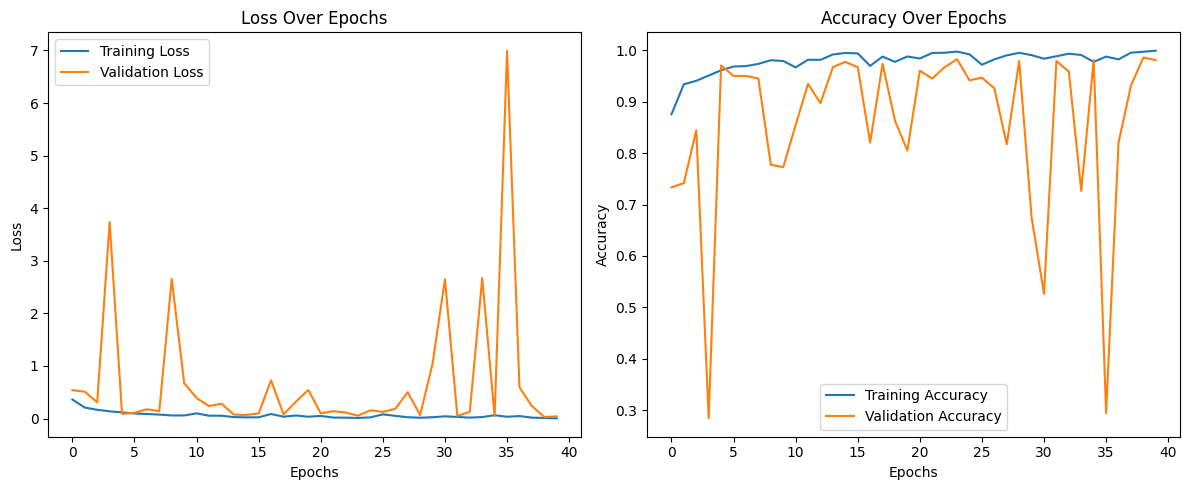

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step

Performance on Test Data
Precision: 0.9706612144702639
Recall: 0.9701365187713311
F1 Score: 0.9702944945990478
Accuracy: 0.9701365187713311
Confusion Matrix:
            NORMAL  PNEUMONIA
NORMAL        305         12
PNEUMONIA      23        832


In [ ]:
# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Train the model
history = model.fit(train_generator, epochs=40, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation function
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Evaluate the model
evaluate_model(test_generator, model, ['NORMAL', 'PNEUMONIA'], title="Performance on Test Data")


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
    GlobalAveragePooling2D, Dense, concatenate, AveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Dataset path
data_dir = "/content/Chest_XRay_Dataset"  # Corrected dataset path

# Define Swish Activation
def swish(x):
    return x * tf.nn.sigmoid(x)

# Define a Dense Block
def dense_block(x, num_layers, growth_rate, activation=swish):
    for _ in range(num_layers):
        # Bottleneck Layer
        bn = BatchNormalization()(x)
        act = Activation(activation)(bn)
        conv = Conv2D(4 * growth_rate, (1, 1), padding='same', kernel_initializer='he_normal')(act)

        # 3x3 Convolution Layer
        bn = BatchNormalization()(conv)
        act = Activation(activation)(bn)
        conv = Conv2D(growth_rate, (3, 3), padding='same', kernel_initializer='he_normal')(act)

        # Concatenate
        x = concatenate([x, conv])
    return x

# Transition Block
def transition_block(x, compression=0.5, activation=swish):
    num_filters = int(tf.keras.backend.int_shape(x)[-1] * compression)
    bn = BatchNormalization()(x)
    act = Activation(activation)(bn)
    conv = Conv2D(num_filters, (1, 1), padding='same', kernel_initializer='he_normal')(act)
    x = AveragePooling2D((2, 2), strides=2, padding='same')(conv)
    return x

# Build DenseNet Model
def build_densenet(input_shape, num_classes, num_blocks=3, growth_rate=32, num_layers_per_block=4, activation=swish):
    inputs = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Dense Blocks with Transition Layers
    for _ in range(num_blocks - 1):
        x = dense_block(x, num_layers=num_layers_per_block, growth_rate=growth_rate, activation=activation)
        x = transition_block(x, compression=0.5, activation=activation)

    # Final Dense Block
    x = dense_block(x, num_layers=num_layers_per_block, growth_rate=growth_rate, activation=activation)

    # Classification Head
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Define parameters for DenseNet
input_shape = (224, 224, 3)  # Define the input shape for your X-ray images
num_classes = 2  # For binary classification (e.g., NORMAL vs. PNEUMONIA)
model = build_densenet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 112, 112, 64)   │            256 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_27             │ (None, 112, 112, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ activation_27[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 56, 56, 64)     │            256 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_28             │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 56, 56, 128)    │          8,320 │ activation_28[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 56, 56, 128)    │            512 │ conv2d_28[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_29             │ (None, 56, 56, 128)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 56, 56, 32)     │         36,896 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 56, 56, 96)     │              0 │ max_pooling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 56, 56, 96)     │            384 │ concatenate_12[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_30             │ (None, 56, 56, 96)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 726,642 (2.77 MB)

 Trainable params: 718,802 (2.74 MB)

 Non-trainable params: 7,840 (30.62 KB)

Found 4099 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 90s 333ms/step - accuracy: 0.8317 - loss: 0.4323 - val_accuracy: 0.7299 - val_loss: 0.7186
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - accuracy: 0.9178 - loss: 0.2332 - val_accuracy: 0.7248 - val_loss: 0.7457
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.9452 - loss: 0.1801 - val_accuracy: 0.7316 - val_loss: 0.6001
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.9457 - loss: 0.1615 - val_accuracy: 0.8171 - val_loss: 0.3641
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9461 - loss: 0.1497 - val_accuracy: 0.8308 - val_loss: 0.5575
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.9506 - loss: 0.1290 - val_accuracy: 0.8957 - val_loss: 0.2267
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.9743 - loss: 0.0871 - val_accuracy: 0.2940 - val_loss: 10.3937
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.9617 - loss: 0.0989 - va

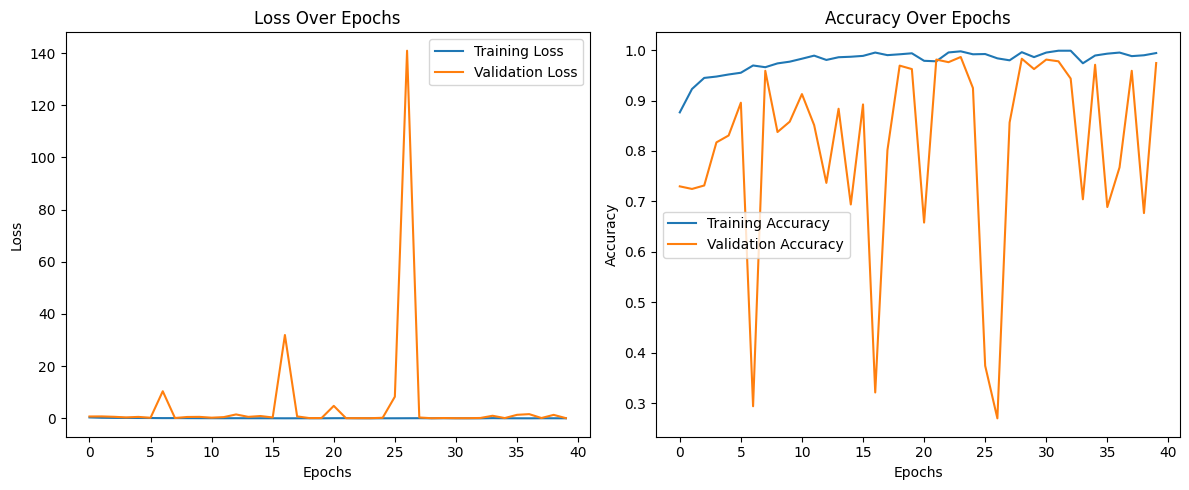

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step

Performance on Test Data
Precision: 0.9545051702421584
Recall: 0.9547781569965871
F1 Score: 0.9545709415149294
Accuracy: 0.9547781569965871
Confusion Matrix:
            NORMAL  PNEUMONIA
NORMAL        286         31
PNEUMONIA      22        833


In [ ]:
# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Train the model
history = model.fit(train_generator, epochs=40, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# Evaluation function
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Evaluate the model
evaluate_model(test_generator, model, ['NORMAL', 'PNEUMONIA'], title="Performance on Test Data")
